In [42]:
from model_B import Model_B
from dataset import *
from torch.utils.data import Dataset, DataLoader 
from matplotlib import pyplot as plt 
import numpy as np
# data_path = "./data/dataset/PCC_50cycle_directACK.csv"
# data_path = "./data/dataset/PCC_50cycle_EWMAACK.csv"
# data_path = "./data/train.csv"
data_path = "./data/motor_001.csv"

HISTORY_LEN = 10
FORECAST_LEN = 3
INTERVAL = FORECAST_LEN

trainSet = MotorData(data_path=data_path, history_len=HISTORY_LEN, forecast_len=FORECAST_LEN, interval=INTERVAL, train=True)
testSet = MotorData(data_path=data_path, history_len=HISTORY_LEN, forecast_len=FORECAST_LEN, interval=INTERVAL, train=False)
# trainSet = RTTData(data_path=data_path, history_len=HISTORY_LEN, forecast_len=FORECAST_LEN, interval=INTERVAL, train=True)
# testSet = RTTData(data_path=data_path, history_len=HISTORY_LEN, forecast_len=FORECAST_LEN, interval=INTERVAL, train=False)
trainLoader = DataLoader(dataset=trainSet, batch_size=16,shuffle=True)
testLoader = DataLoader(dataset=testSet, batch_size=16,shuffle=False)

split_index is  1061
split_index is  1061


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model_B(name='LSTMNet_1',history_len=HISTORY_LEN,forecast_len=FORECAST_LEN).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
mse_func = torch.nn.MSELoss()
mae_func = torch.nn.L1Loss()

model.train()
count=0
total = 0
for epoch in range(100):
    for i, data in enumerate(trainLoader):
        ## x.size() = (batch_size, seq_len)
        ## y.size() = (batch_size. 1)
        x, (y_reg, y_cla) = data 
        x = x.unsqueeze(2).to(device)
        y_reg = y_reg.to(device)

        out_reg = model(x)
        mse_loss = mse_func(out_reg,y_reg)
        mae_loss = mae_func(out_reg,y_reg)
        
        loss = mse_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'epoch #{epoch} mse loss: {mse_loss} | rmse loss: {mse_loss**0.5} | mae loss: {mae_loss}')

epoch #0 mse loss: 0.5561231374740601 | rmse loss: 0.7457366585731506 | mae loss: 0.6227747201919556
epoch #1 mse loss: 0.060932159423828125 | rmse loss: 0.24684439599514008 | mae loss: 0.20394068956375122
epoch #2 mse loss: 0.0740344226360321 | rmse loss: 0.27209267020225525 | mae loss: 0.20653343200683594
epoch #3 mse loss: 0.05076100677251816 | rmse loss: 0.22530204057693481 | mae loss: 0.20339414477348328
epoch #4 mse loss: 0.05486423894762993 | rmse loss: 0.2342311590909958 | mae loss: 0.20460274815559387
epoch #5 mse loss: 0.04917173832654953 | rmse loss: 0.2217470109462738 | mae loss: 0.18748417496681213
epoch #6 mse loss: 0.04579264298081398 | rmse loss: 0.2139921635389328 | mae loss: 0.18118280172348022
epoch #7 mse loss: 0.06442366540431976 | rmse loss: 0.25381818413734436 | mae loss: 0.21455173194408417
epoch #8 mse loss: 0.043335650116205215 | rmse loss: 0.20817215740680695 | mae loss: 0.17495307326316833
epoch #9 mse loss: 0.04626862332224846 | rmse loss: 0.215101420879364

In [44]:
model.eval()
results_reg = []
labels_reg = []
correct = 0
total = 0
# count_label = 0
# count_pred = 0
confusion = torch.zeros(2,2)

total_mse_loss = 0
total_rmse_loss = 0
total_mae_loss = 0

with torch.no_grad():
    for i, data in enumerate(testLoader):
            x, (y_reg, y_cla) = data
            ## x.size() = (batch_size, seq_len)
            ## y.size() = (batch_size. 1)
            if(i==0):
                results_reg+=list(x[0].numpy())
                labels_reg+=list(x[0].numpy())          
            x = x.unsqueeze(2).to(device)
            out_reg = model(x)     
            mse_loss = mse_func(out_reg,y_reg)
            mae_loss = mae_func(out_reg,y_reg)
            total_mse_loss += mse_loss
            total_rmse_loss += mse_loss**0.5
            total_mae_loss += mae_loss
            label_reg = list(np.concatenate(y_reg.numpy()))     
            results_reg+=list(np.concatenate(out_reg.cpu().numpy()))
            labels_reg+=label_reg

print(f"mse loss = {total_mse_loss/len(testLoader)}")
print(f"rmse loss = {total_rmse_loss/len(testLoader)}")
print(f"mae loss = {total_mae_loss/len(testLoader)}")

mse loss = 0.006902134511619806
rmse loss = 0.08208741247653961
mae loss = 0.06470347940921783


451
451
451
451


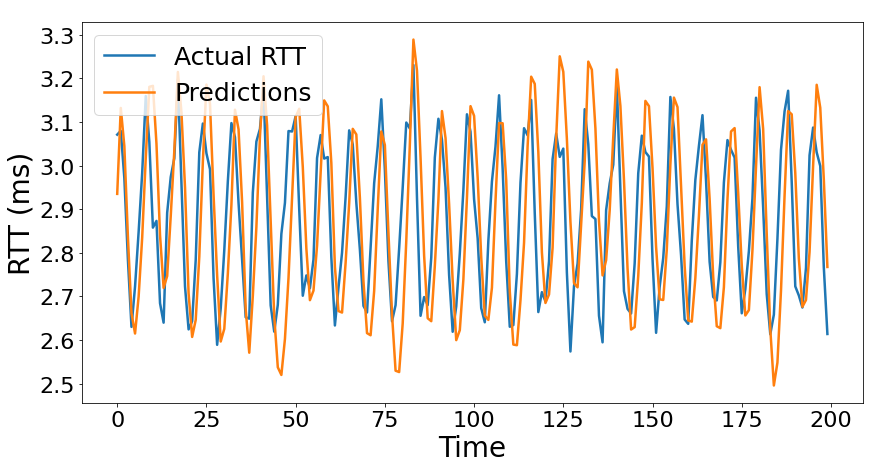

In [45]:
import numpy as np

LINE_WIDTH=2.5
FONT_SIZE = 28

results_reg = np.array(results_reg)
# results_cla = np.array(results_cla)
labels_reg = np.array(labels_reg)
# labels_cla = np.array(labels_cla)

print(len(results_reg))
print(len(labels_reg))
# print(results_reg[0:20])

plt.figure(figsize=(14,7))#设置画布的尺寸
plt.title('Examples of line chart',fontsize=20)#标题，并设定字号大小
plt.xlabel('time',fontsize=14)#设置x轴，并设定字号大小
plt.ylabel('elec',fontsize=14)#设置y轴，并设定字号大小
 

plot_range = [200,400]
plot_len = plot_range[1] - plot_range[0]

print(len(results_reg))
print(len(labels_reg))

SHIFT = -1

plt.plot(list(range(plot_len)), results_reg[plot_range[0]:plot_range[1]], label='Actual RTT',  linewidth=LINE_WIDTH)
plt.plot(list(range(plot_len)), labels_reg[plot_range[0]+SHIFT:plot_range[1]+SHIFT], label='Predictions',  linewidth=LINE_WIDTH)
plt.legend(loc='upper left', fontsize=25)

#设置坐标标签标注和字体大小
plt.xlabel("Time",fontsize=FONT_SIZE)
plt.ylabel("RTT (ms)",fontsize=FONT_SIZE)

#设置坐标刻度字体大小
plt.xticks(fontsize=FONT_SIZE*0.8)
plt.yticks(fontsize=FONT_SIZE*0.8)

plt.title(" ")
plt.savefig(f"./sample.png",bbox_inches = 'tight')
plt.show()

In [1]:
import time

In [2]:
time.time()

1647952424.4336195